# Causal Learning

## Imports

In [5]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from causalnex.discretiser import Discretiser
from causalnex.structure import DAGRegressor
from causalnex.inference import InferenceEngine
from causalnex.network import BayesianNetwork
from causalnex.network.sklearn import BayesianNetworkClassifier
from causalnex.structure.notears import from_pandas
from causalnex.utils.network_utils import get_markov_blanket
from causalnex.structure.notears import from_pandas, from_pandas_lasso
from causalnex.discretiser.discretiser_strategy import ( DecisionTreeSupervisedDiscretiserMethod )

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score

In [6]:
sns.set()
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', '{:.2f}'.format)

In [7]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))

In [8]:
from file_handler import FileHandler
import vis_seaborn as vs
from eda_helper import Helper
from df_overview import DfOverview

In [9]:
helper = Helper()

## Data reading

In [43]:
fh = FileHandler()
df = fh.read_csv("../data/data.csv")
df.head(5)

INFO:file_handler:Csv file read from ../data/data.csv.


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.00,0.12,0.23,0.28,0.15,0.24,0.08,0.85,0.91,5.98,86.20,0.01,0.05,0.05,0.02,0.03,0.01,25.38,17.33,184.60,1937.05,0.16,0.63,0.71,0.27,0.42,0.12
1,842517,M,20.57,17.77,132.90,1326.00,0.08,0.08,0.09,0.07,0.18,0.06,0.54,0.73,3.40,74.08,0.01,0.01,0.02,0.01,0.01,0.00,24.99,23.41,158.80,1937.05,0.12,0.19,0.24,0.19,0.28,0.09
2,84300903,M,19.69,21.25,130.00,1203.00,0.11,0.16,0.20,0.13,0.21,0.06,0.75,0.79,4.58,86.20,0.01,0.04,0.04,0.02,0.02,0.00,23.57,25.53,152.50,1709.00,0.14,0.42,0.45,0.24,0.36,0.09
3,84348301,M,11.42,20.38,77.58,386.10,0.13,0.23,0.24,0.11,0.25,0.08,0.50,1.16,3.44,27.23,0.01,0.06,0.06,0.02,0.04,0.01,14.91,26.50,98.87,567.70,0.19,0.63,0.69,0.26,0.42,0.12
4,84358402,M,20.29,14.34,135.10,1297.00,0.10,0.13,0.20,0.10,0.18,0.06,0.76,0.78,5.44,86.20,0.01,0.02,0.06,0.02,0.02,0.01,22.54,16.67,152.20,1575.00,0.14,0.20,0.40,0.16,0.24,0.08


In [45]:
y = df.diagnosis  # M or B
x = df.drop(['diagnosis'], axis=1)

In [27]:
feat = ['diagnosis', 'perimeter_worst', 'area_worst', 'radius_worst', 'concave points_worst', 'concave points_mean', 'perimeter_mean', 'area_mean', 'radius_mean', 'area_se', 'concavity_mean', 'concavity_worst', 'perimeter_se', 'radius_se', 'compactness_worst', 'compactness_mean', 'texture_worst', 'concave points_se', 'smoothness_worst', 'texture_mean', 'symmetry_worst', 'concavity_se', 'smoothness_mean', 'symmetry_mean', 'compactness_se', 'fractal_dimension_worst', 'fractal_dimension_se', 'texture_se', 'fractal_dimension_mean', 'symmetry_se', 'smoothness_se']

In [63]:
x = df[feat[:29]]
x['diagnosis'] = x['diagnosis'].apply(lambda x: 1 if x == "M" else 0)
x.head(5)

,diagnosis,perimeter_worst,area_worst,radius_worst,concave points_worst,concave points_mean,perimeter_mean,area_mean,radius_mean,area_se,concavity_mean,concavity_worst,perimeter_se,radius_se,compactness_worst,compactness_mean,texture_worst,concave points_se,smoothness_worst,texture_mean,symmetry_worst,concavity_se,smoothness_mean,symmetry_mean,compactness_se,fractal_dimension_worst,fractal_dimension_se,texture_se,fractal_dimension_mean
0,1,184.60,1937.05,25.38,0.27,0.15,122.80,1001.00,17.99,86.20,0.28,0.71,5.98,0.85,0.63,0.23,17.33,0.02,0.16,10.38,0.42,0.05,0.12,0.24,0.05,0.12,0.01,0.91,0.08
1,1,158.80,1937.05,24.99,0.19,0.07,132.90,1326.00,20.57,74.08,0.09,0.24,3.40,0.54,0.19,0.08,23.41,0.01,0.12,17.77,0.28,0.02,0.08,0.18,0.01,0.09,0.00,0.73,0.06
2,1,152.50,1709.00,23.57,0.24,0.13,130.00,1203.00,19.69,86.20,0.20,0.45,4.58,0.75,0.42,0.16,25.53,0.02,0.14,21.25,0.36,0.04,0.11,0.21,0.04,0.09,0.00,0.79,0.06
3,1,98.87,567.70,14.91,0.26,0.11,77.58,386.10,11.42,27.23,0.24,0.69,3.44,0.50,0.63,0.23,26.50,0.02,0.19,20.38,0.42,0.06,0.13,0.25,0.06,0.12,0.01,1.16,0.08
4,1,152.20,1575.00,22.54,0.16,0.10,135.10,1297.00,20.29,86.20,0.20,0.40,5.44,0.76,0.20,0.13,16.67,0.02,0.14,14.34,0.24,0.06,0.10,0.18,0.02,0.08,0.01,0.78,0.06


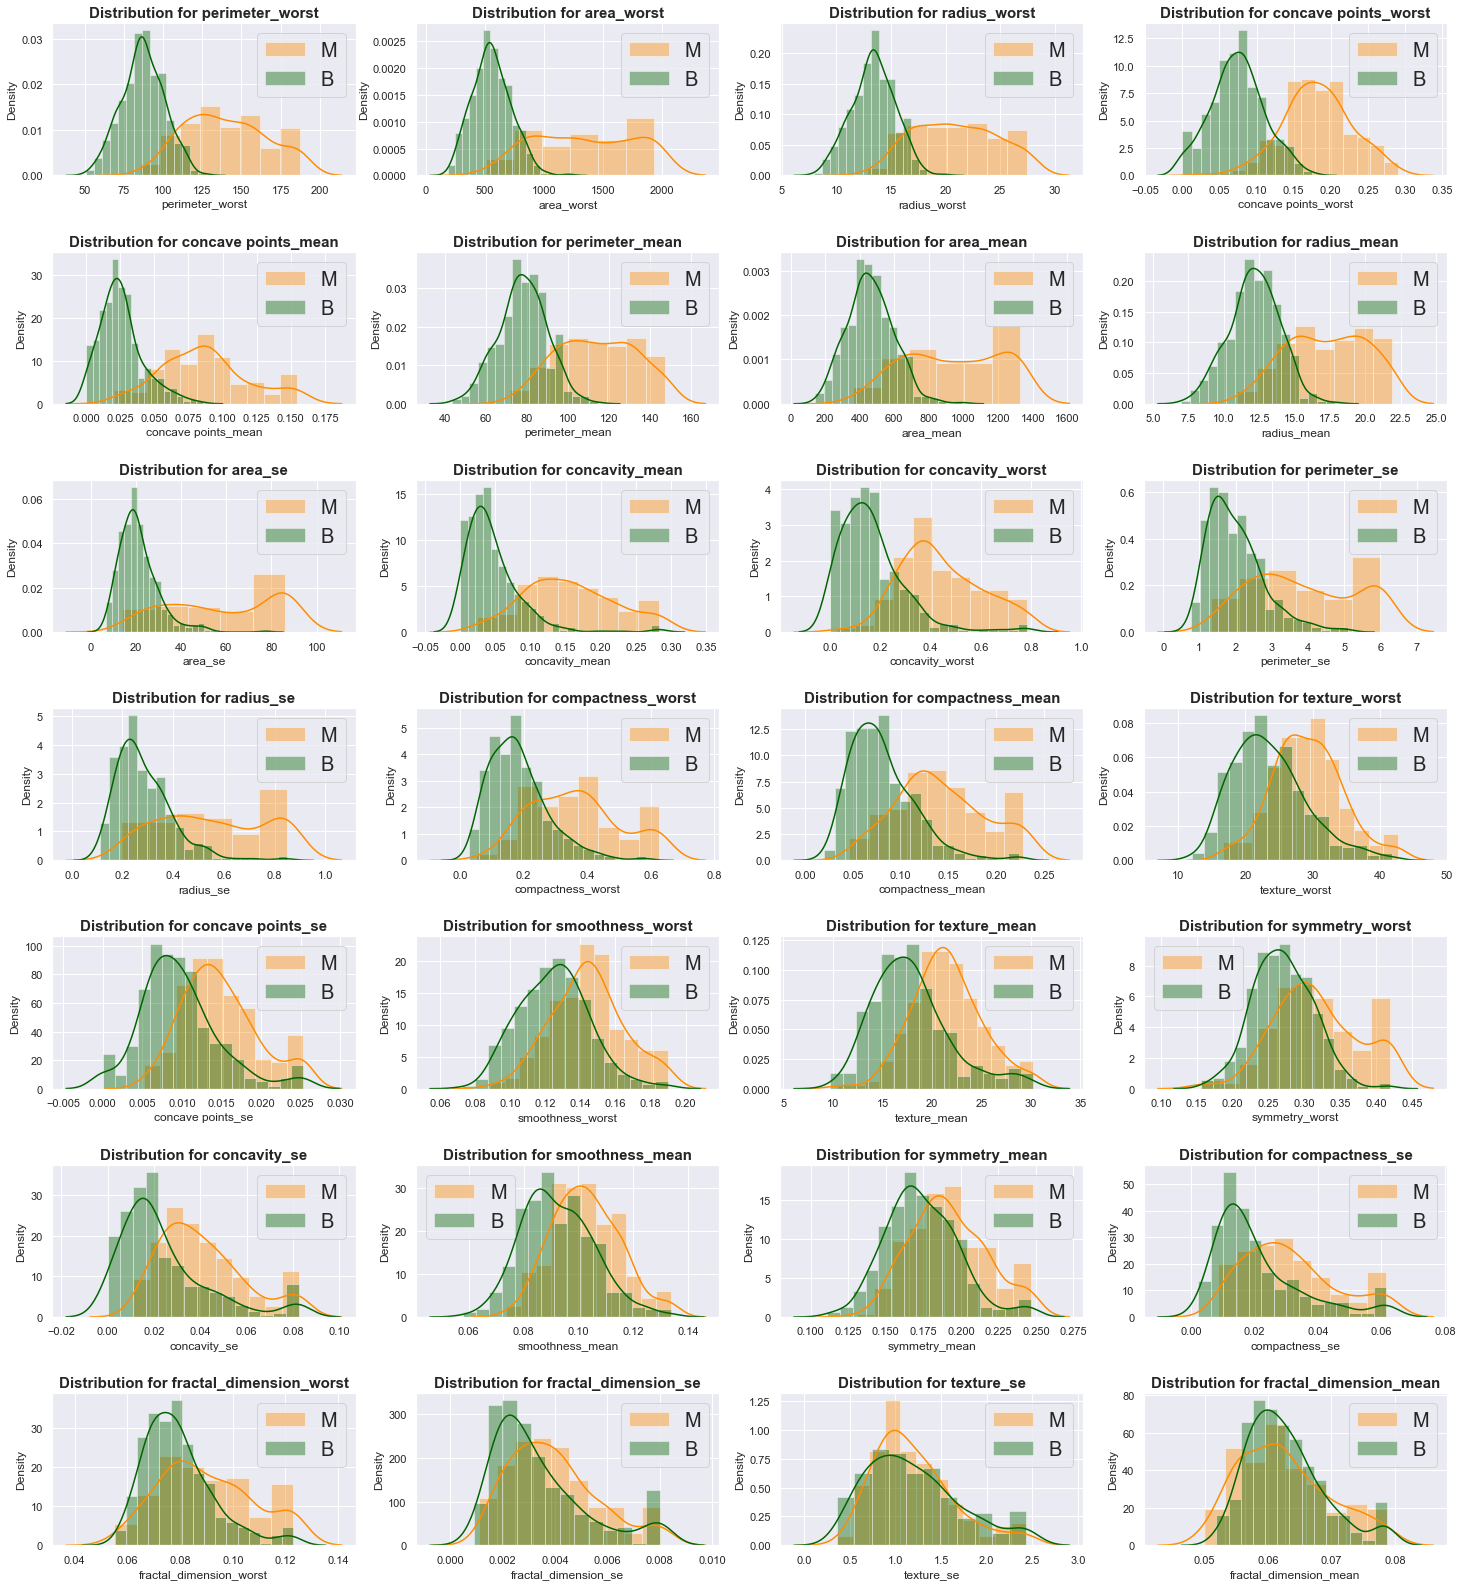

In [73]:
num_feat = x.shape[1]-1
fig = plt.figure(figsize=(25, num_feat))
fig.subplots_adjust(hspace=.5)
axs = [fig.add_subplot(num_feat / 4, 4, i + 1) for i in range(num_feat)]

for i, column in enumerate(x.columns[1:]):
    sns.distplot(x[x.diagnosis == 1][column], ax=axs[i], color='darkorange', label="M")
    sns.distplot(x[x.diagnosis == 0][column], ax=axs[i], color='darkgreen', label="B")
    axs[i].set_title('Distribution for {}'.format( column), fontweight='bold', fontsize=15)
    axs[i].legend(fontsize=20)
plt.show()

In [9]:
%%time
sm = from_pandas(x)

CPU times: user 5min 39s, sys: 5.13 s, total: 5min 44s
Wall time: 3min 24s


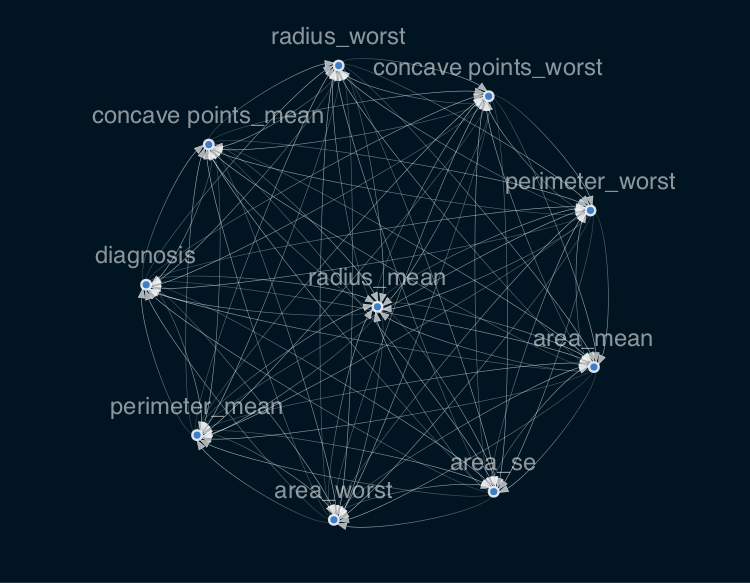

In [10]:
vs.vis_sm(sm)

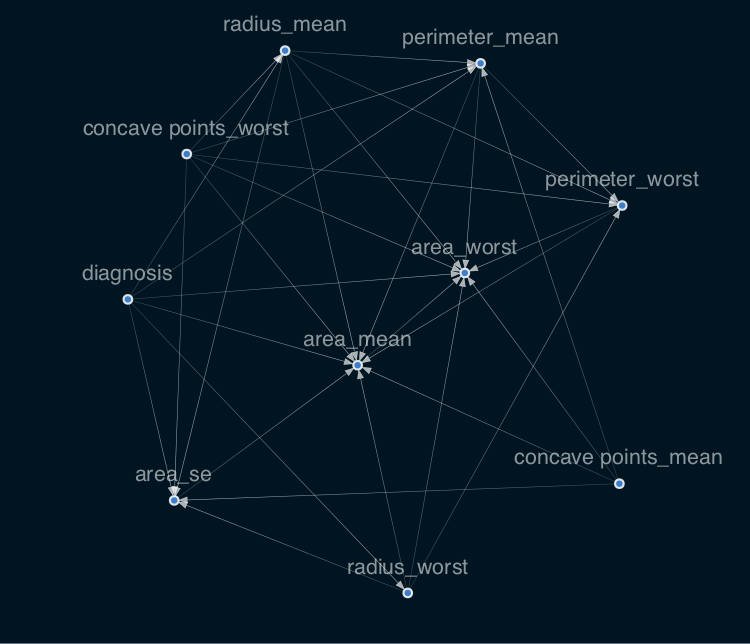

In [11]:
sm.remove_edges_below_threshold(0.8)
vs.vis_sm(sm)

## B

In [31]:
%%time
sm = from_pandas_lasso( x, 
                        tabu_parent_nodes=['diagnosis'], 
                        w_threshold=0.3, 
                        beta=0.8)

CPU times: user 1min 22s, sys: 996 ms, total: 1min 23s
Wall time: 45.2 s


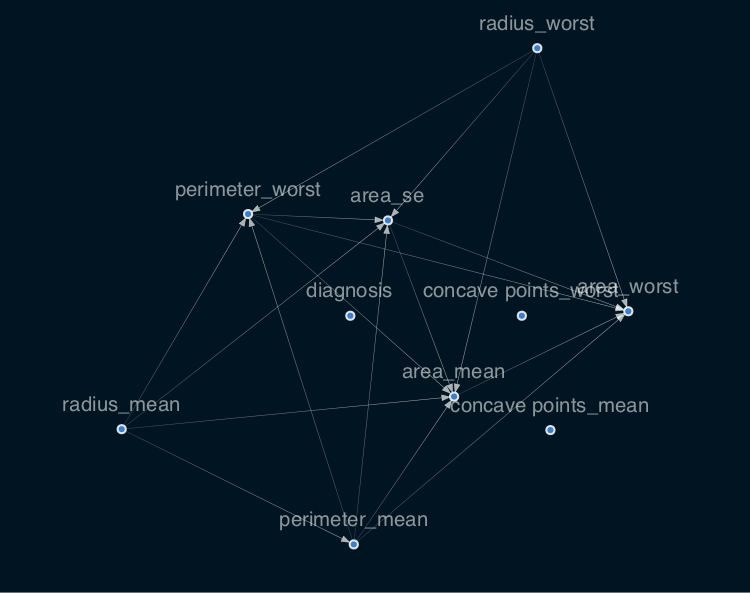

In [32]:
vs.vis_sm(sm)

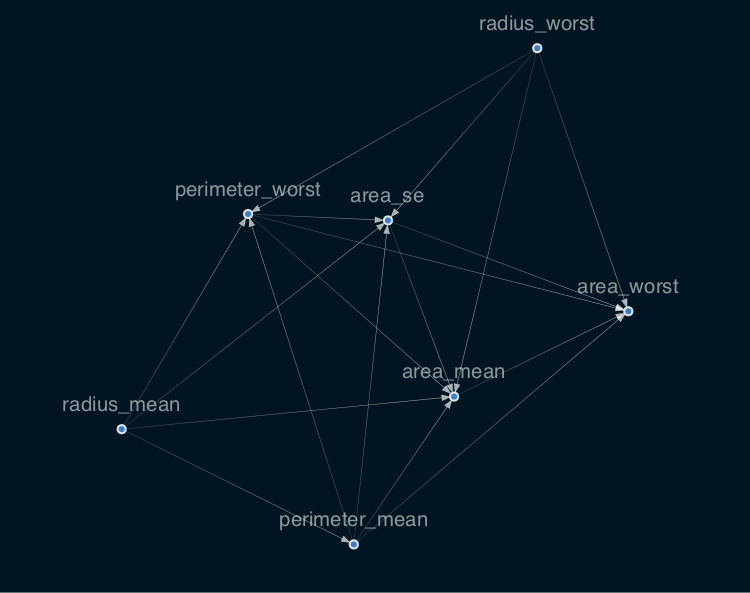

In [33]:
sm = sm.get_largest_subgraph()
vs.vis_sm(sm)

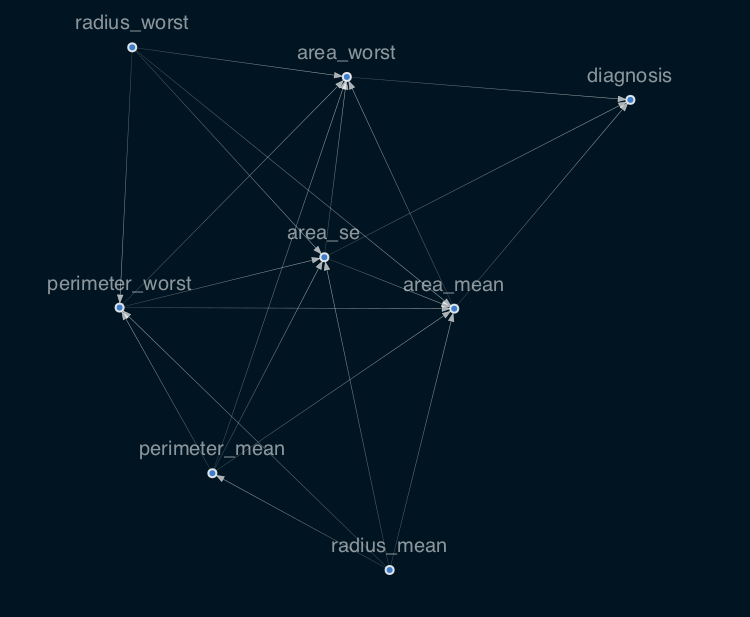

In [34]:
sm.add_edge("area_mean", "diagnosis")
sm.add_edge("area_se", "diagnosis")
sm.add_edge("area_worst", "diagnosis")
vs.vis_sm(sm)

## Discretising Numeric Features

In [54]:
df_overview = DfOverview(x)
overview = df_overview.getOverview()
vs.view_df(overview[["count", "unique_value_count", "unique_percentage"]],
                    ["count", "unique_value_count"])

,label,count,unique_value_count,unique_percentage
0,DIAGNOSIS,569,2,0.35%
1,PERIMETER_WORST,569,500,87.87%
2,AREA_WORST,569,510,89.63%
3,RADIUS_WORST,569,441,77.5%
4,CONCAVE POINTS_WORST,569,492,86.47%
5,CONCAVE POINTS_MEAN,569,533,93.67%
6,PERIMETER_MEAN,569,511,89.81%
7,AREA_MEAN,569,515,90.51%
8,RADIUS_MEAN,569,443,77.86%
9,AREA_SE,569,465,81.72%


In [55]:
features = list(x.columns.difference(['diagnosis']))
features

['area_mean',
 'area_se',
 'area_worst',
 'concave points_mean',
 'concave points_worst',
 'perimeter_mean',
 'perimeter_worst',
 'radius_mean',
 'radius_worst']

In [56]:
tree_discretiser = DecisionTreeSupervisedDiscretiserMethod(
    mode='single',
    tree_params={'max_depth': 3, 'random_state': 27},
)
tree_discretiser.fit(
    feat_names=features,
    dataframe=x,
    target_continuous=True,
    target='diagnosis',
)
tree_discretiser

DecisionTreeSupervisedDiscretiserMethod(tree_params={'max_depth': 3,
                                                     'random_state': 27})

In [57]:
discretised_data = x.copy()
for col in features:
    discretised_data[col] = tree_discretiser.transform(x[[col]])

In [58]:
df_overview = DfOverview(discretised_data)
overview = df_overview.getOverview()
vs.view_df(overview[["count", "unique_value_count", "unique_percentage"]],
           ["count", "unique_value_count"])

,label,count,unique_value_count,unique_percentage
0,DIAGNOSIS,569,2,0.35%
1,PERIMETER_WORST,569,8,1.41%
2,AREA_WORST,569,8,1.41%
3,RADIUS_WORST,569,8,1.41%
4,CONCAVE POINTS_WORST,569,8,1.41%
5,CONCAVE POINTS_MEAN,569,8,1.41%
6,PERIMETER_MEAN,569,8,1.41%
7,AREA_MEAN,569,8,1.41%
8,RADIUS_MEAN,569,8,1.41%
9,AREA_SE,569,8,1.41%


## Reducing a graph to its Markov Blanket

Now, assume that target is our variable of interest. We actually do not need all the nodes in the network but only the MB of target. To achieve that, we simply need to use the get_markov_blanket function from causalnex. Specifically,

In [89]:
bn = BayesianNetwork(sm)
blanket = get_markov_blanket(bn, 'diagnosis')
edge_list = list(blanket.structure.edges)
edge_list

[('area_worst', 'diagnosis'),
 ('area_mean', 'area_worst'),
 ('area_mean', 'diagnosis'),
 ('area_se', 'area_worst'),
 ('area_se', 'area_mean'),
 ('area_se', 'diagnosis')]

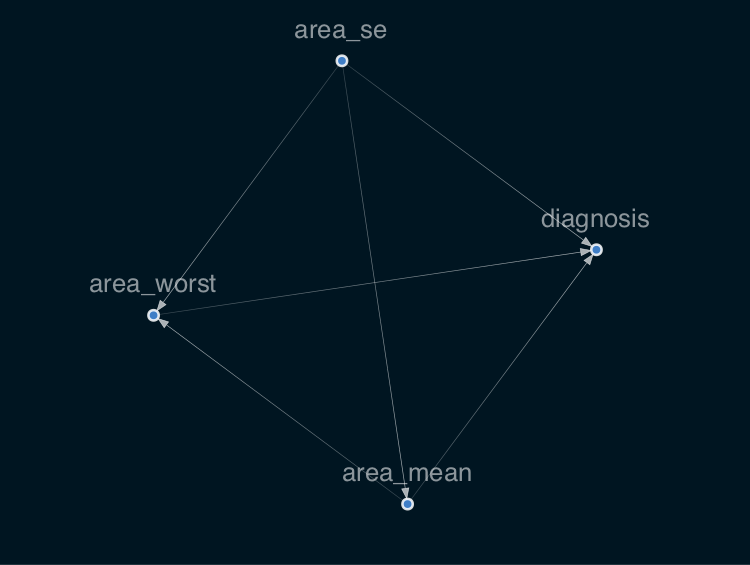

In [36]:
vs.vis_sm(blanket.structure)

## Bayesian Network

In [92]:
label = discretised_data['diagnosis']
input_data = discretised_data.drop(['diagnosis'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(input_data, label, test_size=0.05, random_state=7)

In [93]:

clf = BayesianNetworkClassifier(
    edge_list,
    discretiser_alg=label,
    discretiser_kwargs=input_data,
)

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [61]:
train, test = train_test_split(
    discretised_data, train_size=0.8, test_size=0.2, random_state=7)
bn = bn.fit_node_states(discretised_data)
bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

In [ ]:
target_map = {0: "Benign", 1: "Malignant"}
discretised_data["diagnosis"] = (discretised_data["diagnosis"].map(target_map))

In [76]:
pred = bn.predict(test, 'diagnosis')
true = test['diagnosis']

In [77]:
print('Recall: {:.2f}'.format(recall_score(y_true=true, y_pred=pred)))
print('F1: {:.2f} '.format(f1_score(y_true=true, y_pred=pred)))
print('Accuracy: {:.2f} '.format(accuracy_score(y_true=true, y_pred=pred)))
print('Precision: {:.2f} '.format(precision_score(y_true=true, y_pred=pred)))

Recall: 0.78
F1: 0.87 
Accuracy: 0.92 
Precision: 1.00 


## Inference


In [78]:
ie = InferenceEngine(bn)

What would be the Outcome if all people actually had healthy weight? — If all people were with healthy weight, there will be less positive diagnosis.(from 0.42 to 0.30)

In [80]:
observation_1 = {"area_mean": 1, "area_se": 1, "area_worst": 1}
observation_2 = {"area_mean": 2, "area_se": 2, "area_worst": 2}
marginals = ie.query([observation_1, observation_2])[]


In [83]:
for m in marginals:
  print(m['diagnosis'])

{0: 0.5, 1: 0.5}
{0: 0.5, 1: 0.5}
